# Homework 4
### ASTROINFORMATICS
https://github.com/astromundus/astroinfo2018


## Problem

The flux vs. time plot below shows UV flux measurements for an active M dwarf
star. These stars are known for their exponential bursts of energy, well described
by the profile:

$$\rm{flux(time)} = A\,exp(-\alpha \, t)$$ 

for $t>T$ (recall Week-5-Thu lecture).

Find how many bursts were observed for this star during the provided 2 hour 
stretch of data and estimate their amplitudes (A), decay constants ($\alpha$),
and the time of bursts.

**Hints:**
- You can relatively easily solve this problem by generalizing the code from [fig. 10.25](http://www.astroml.org/book_figures/chapter10/fig_matchedfilt_burst.html)
- There are no more than 2 bursts in this dataset. I.e., you can fit a single-burst model, and then a double-burst model, and then compare which one fits better. Show the posteriors plots (like in [fig. 10.25](http://www.astroml.org/book_figures/chapter10/fig_matchedfilt_burst.html)) for both models.
- You can use flat priors for A and T and the background (non-bursting) flux level, and Jeffreys' prior, $p(\alpha) \propto \alpha^{-1}$, for $\alpha$
- You can do approximate model comparison based on the BIC 

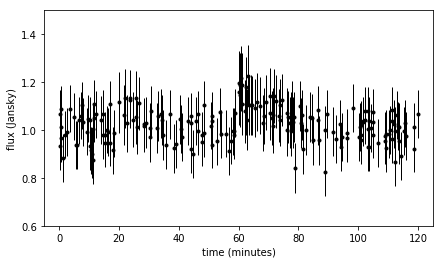

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# read data
data = np.loadtxt('HW4dataFinal.txt', unpack=True)
t, y_obs, sigma_y = data

y1=np.log10(y_obs)
sig1=np.log10(sigma_y)
# plot data
fig = plt.figure(figsize=(12, 12))
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
ax.errorbar(t, y1, sig1, fmt='.', lw=1, c='k')
ax.set_xlim(-5, 125)
ax.set_ylim(0.6, 1.501)
ax.set_xlabel('time (minutes)')
ax.set_ylabel(r'flux (Jansky)')

plt.show()

## Solution


 [-----------------100%-----------------] 25000 of 25000 complete in 6.8 sec
AIC=  741.5746734588139 BIC=  754.767942925
(array(10.441571987732784), array(7.6330121511493685), 0.36788052443111796, array(59.31484178791996))
Ndata = 200 DOF = 4
chi2dof = 1.37457578828


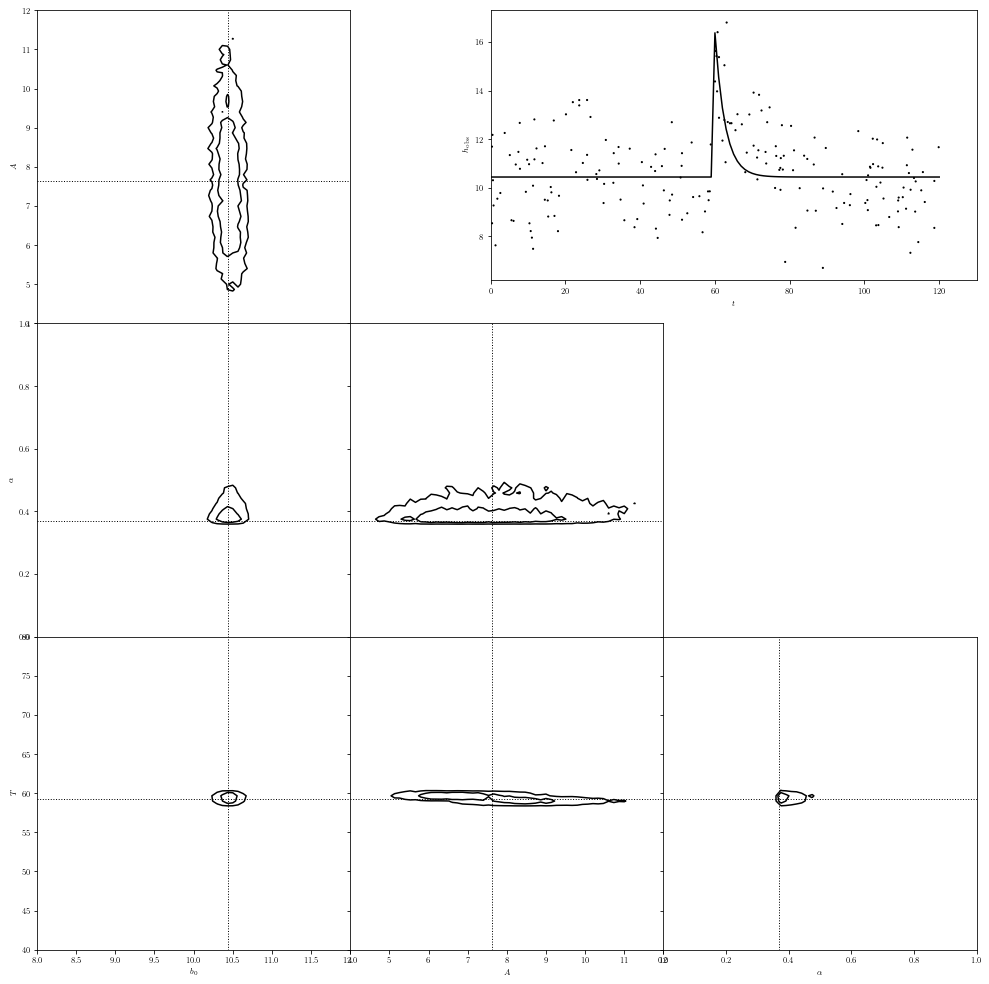

In [26]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
# Hack to fix import issue in older versions of pymc
import scipy
import scipy.misc
scipy.derivative = scipy.misc.derivative
import pymc

from astroML.plotting.mcmc import plot_mcmc
from astroML.decorators import pickle_results

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)


#----------------------------------------------------------------------
# Set up toy dataset
def burst(t, b0, A, alpha, T):
    """Burst model"""
    y = np.empty(t.shape)
    y.fill(b0)
    mask = (t >= T)
    y[mask] += A * np.exp(-(alpha) * (t[mask] - T))
    return y



np.random.seed(432)

# read data
data = np.loadtxt('HW4dataFinal.txt', unpack=True)
t, y_obs, sigma_y = data


#----------------------------------------------------------------------
# Set up MCMC sampling
b0 = pymc.Uniform('b0', 0, 20, value=20 * np.random.random())
A = pymc.Uniform('A', 0, 20, value=20 * np.random.random())
T = pymc.Uniform('T', 0, 120, value=120 * np.random.random())
log_alpha = pymc.Uniform('log_alpha', -1, 1, value=0)


# uniform prior on log(alpha)
@pymc.deterministic
def alpha(log_alpha=log_alpha):
    return np.exp(log_alpha)

                 
@pymc.deterministic
                  
def y_model(t=t, b0=b0, A=A, alpha=alpha, T=T):
#    print(alpha)
    return burst(t, b0, A, alpha, T)


y = pymc.Normal('y', mu=y_model, tau=sigma_y ** -2, observed=True, value=y_obs)


model = dict(b0=b0, A=A, T=T, log_alpha=log_alpha,
             alpha=alpha, y_model=y_model, y=y)


#----------------------------------------------------------------------
# Run the MCMC sampling
#@pickle_results('matchedfilt_burst.pkl')
def compute_MCMC_results(niter=25000, burn=4000):
    S = pymc.MCMC(model)
    S.sample(iter=niter, burn=burn)
    traces = [S.trace(s)[:] for s in ['b0', 'A',  'alpha', 'T']]

   
    M = pymc.MAP(model)
    M.fit()
    fit_vals = (M.b0.value, M.A.value, M.alpha.value, M.T.value)

    print()
    print('AIC= ', M.AIC,'BIC= ', M.BIC)
    return traces, fit_vals



traces, fit_vals = compute_MCMC_results()


labels = ['$b_0$', '$A$',  r'$\alpha$', '$T$']
limits = [(8, 12.), (4, 12), (0, 1), (40, 80)]
print(fit_vals)

true=fit_vals
#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(15, 15))
fig.subplots_adjust(bottom=0.1, top=0.95,
                    left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

# This function plots multiple panels with the traces
plot_mcmc(traces, labels=labels, limits=limits, true_values=true, fig=fig,
          bins=60, colors='k')

# Plot the model fit
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
t_fit = np.linspace(0, 120, 121)
y_fit = burst(t_fit, *fit_vals)

y_fita = burst(t, *fit_vals)

chi2 = np.sum(((y_obs-y_fita)/sigma_y)**2) 
# and chi2 per degree of freedom (the number of fitted parameters is 4)

Ndata = len(t)
dof=4
print ('Ndata =',Ndata, 'DOF =', dof)

chi2dof = chi2/(Ndata - dof)

print ('chi2dof =', chi2dof)

ax.scatter(t, y_obs, sigma_y, lw=1, c='k')
#ax.errorbar(t, y_obs, sigma_y, fmt='.', lw=1, c='k')
ax.plot(t_fit, y_fit, '-k')



ax.set_xlim(0, 130)
ax.set_xlabel('$t$')
ax.set_ylabel(r'$h_{\rm obs}$')

plt.show()


 [-----------------100%-----------------] 40000 of 40000 complete in 19.9 sec
AIC=  698.4233069619414 BIC=  721.511528528

(array(10.098604319860776), array(3.98708664549125), 0.36788052443111796, array(23.20181638906576), array(5.028624659777874), 0.10043612515232342, array(59.51656202930646))
Ndata = 200 DOF= 7
chi2dof = 1.14127195858


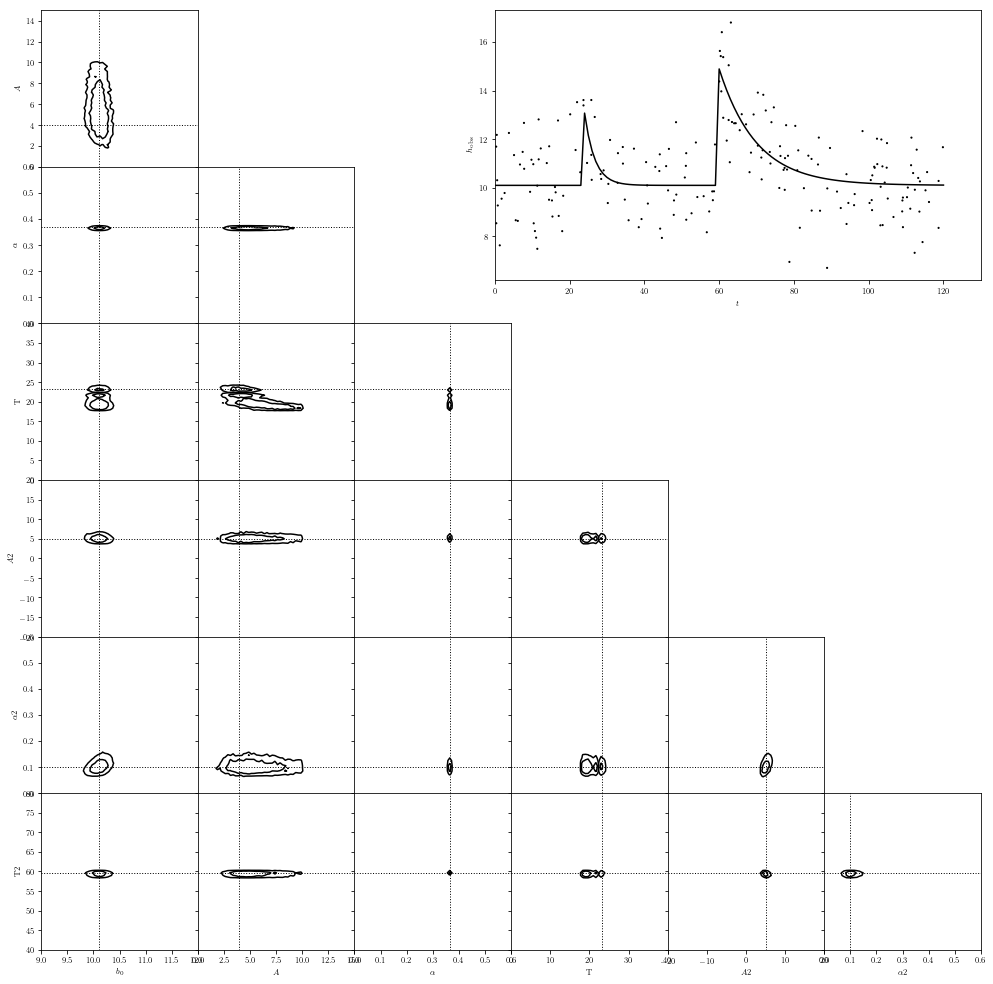

In [27]:

np.random.seed(432)

b0 = pymc.Uniform('b0', 0, 20, value=20 * np.random.random())
A = pymc.Uniform('A', 0, 10, value=10 * np.random.random())
T = pymc.Uniform('T', 0, 120, value=120 * np.random.random())
log_alpha = pymc.Uniform('log_alpha', -5, 1, value=0)
log_alpha2 = pymc.Uniform('log_alpha2', -5, 1, value=0)
A2 = pymc.Uniform('A2', 0, 10, value=10 * np.random.random())
T2 = pymc.Uniform('T2', 0, 120, value=120 * np.random.random())


def burst2 (t, b0, A,alpha, T, A2, alpha2,  T2):
    """Double burst model"""
    y = np.empty(t.shape)
    y.fill(b0)
#    print(b0, A, A2, alpha, alpha2, T, T2)
    mask = (t >= T)
    y[mask] += A * np.exp(-alpha * (t[mask] - T))
    mask2 = (t >= T2)
    y[mask2] += A2 * np.exp(-alpha2 * (t[mask2] - T2))
    return y

@pymc.deterministic

def alpha2(log_alpha2=log_alpha2):
    return np.exp(log_alpha2)

@pymc.deterministic 

def y_model2(t=t, b0=b0, A=A, A2=A2, alpha=alpha, alpha2=alpha2, T=T, T2=T2):
    return burst2(t, b0, A, alpha, T, A2, alpha2, T2)


y2 = pymc.Normal('y', mu=y_model2, tau=sigma_y ** -2, observed=True, value=y_obs)


model2= dict(b0=b0, A=A, A2=A2, T=T, T2=T2, log_alpha=log_alpha, log_alpha2=log_alpha2,
             alpha=alpha, alpha2=alpha2, y_model2=y_model2, y2=y2)



def compute_MCMC_results2(niter=40000, burn=10000):
    S = pymc.MCMC(model2)
    S.sample(iter=niter, burn=burn)
    traces = [S.trace(s)[:] for s in ['b0', 'A', 'alpha', 'T', 'A2',  'alpha2','T2' ]]
#    print(traces)
   
    M = pymc.MAP(model2)
    M.fit()
    fit_vals = (M.b0.value, M.A.value, M.alpha.value, M.T.value, M.A2.value, M.alpha2.value, M.T2.value)
    print()
    print('AIC= ', M.AIC, 'BIC= ',M.BIC)
    print()
    return traces, fit_vals


traces2, fit_vals2 = compute_MCMC_results2()

#print (fit_vals2)

labels = ['$b_0$', '$A$', r'$\alpha$', 'T', '$A2$',  r'$\alpha 2$', 'T2']
limits = [(9., 12), (0, 15),  (0., .6), (0, 40), (-20,20), (0, 0.6), (40, 80) ]
#print(fit_vals)

true=fit_vals2

print(true)
#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(15, 15))
fig.subplots_adjust(bottom=0.1, top=0.95,
                    left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

# This function plots multiple panels with the traces
plot_mcmc(traces2, labels=labels, limits=limits, true_values=true, fig=fig,
          bins=60, colors='k')

# Plot the model fit
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
t_fit = np.linspace(0, 120, 121)
y_fit2 = burst2(t_fit, *fit_vals2)

y_fita2 = burst2(t, *fit_vals2)


chi2 = np.sum(((y_obs-y_fita2)/sigma_y)**2) 
# and chi2 per degree of freedom (the number of fitted parameters is 4)

Ndata = len(t)
dof=7

print ('Ndata =',Ndata, 'DOF=',dof)
chi2dof = chi2/(Ndata - dof)

print ('chi2dof =', chi2dof)

ax.scatter(t, y_obs, sigma_y, lw=1, c='k')
#ax.errorbar(t, y_obs, sigma_y, fmt='.', lw=1, c='k')
ax.plot(t_fit, y_fit2, '-k')



ax.set_xlim(0, 130)
ax.set_xlabel('$t$')
ax.set_ylabel(r'$h_{\rm obs}$')

plt.show()




 [-----------------100%-----------------] 40000 of 40000 complete in 30.9 sec
AIC=  694.0603155872262 BIC=  727.043489253

(array(9.952868856568408), array(2.3035283067265584), 0.36788052443111796, array(96.62140104444738), array(5.045307628762277), 0.10043612515232342, array(59.95077354176614), array(4.458149055648772), 0.14059200913877182, array(18.286160909842547))


/scratch/darko/devel/new_oct18/lsstsw/miniconda/envs/lsst-scipipe/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


Ndata = 200 DOF= 10
chi2dof = 1.10474998227


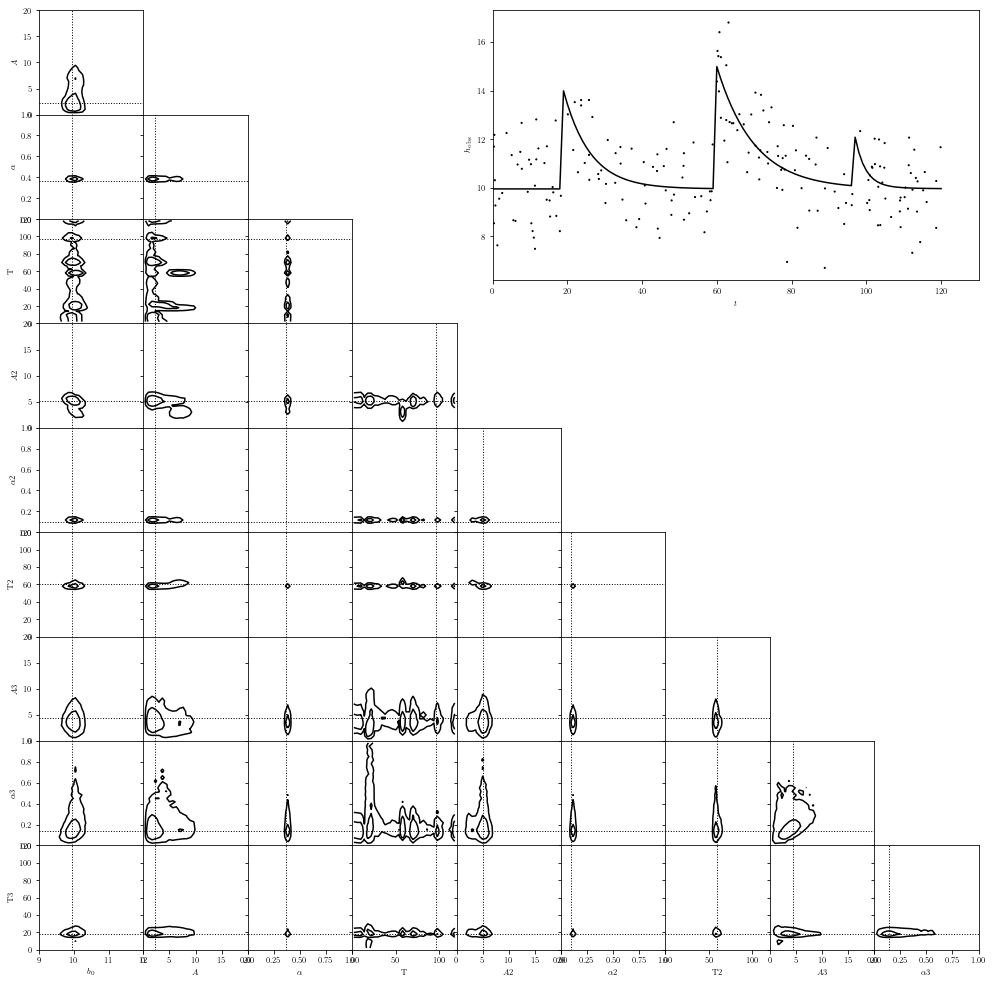

In [32]:

np.random.seed(43200)

b0 = pymc.Uniform('b0', 0, 20, value=20 * np.random.random())
A = pymc.Uniform('A', 1, 10, value=10 * np.random.random())
T = pymc.Uniform('T', 0, 120, value=120 * np.random.random())
log_alpha = pymc.Uniform('log_alpha', -5, 1, value=0)
log_alpha2 = pymc.Uniform('log_alpha2', -5, 1, value=0)
A2 = pymc.Uniform('A2', 1, 10, value=10 * np.random.random())
T2 = pymc.Uniform('T2', 0, 120, value=120 * np.random.random())
log_alpha3 = pymc.Uniform('log_alpha3', -5, 1, value=0)
A3 = pymc.Uniform('A3', 1, 10, value=10 * np.random.random())
T3 = pymc.Uniform('T3', 0, 120, value=120 * np.random.random())


def burst3 (t, b0, A, alpha, T, A2, alpha2,  T2, A3, alpha3,  T3 ):
    """Double burst model"""
    y = np.empty(t.shape)
    y.fill(b0)
#    print(b0, A, A2, alpha, alpha2, T, T2)
    mask = (t >= T)
    y[mask] += A * np.exp(-alpha * (t[mask] - T))
    mask2 = (t >= T2)
    y[mask2] += A2 * np.exp(-alpha2 * (t[mask2] - T2))
    mask3 = (t >= T3)
    y[mask3] += A3 * np.exp(-alpha3 * (t[mask3] - T3))

    return y

@pymc.deterministic

def alpha3(log_alpha3=log_alpha3):
    return np.exp(log_alpha3)

@pymc.deterministic 

def y_model3(t=t, b0=b0, A=A, A2=A2,A3=A3, alpha=alpha, alpha2=alpha2,alpha3=alpha3, T=T, T2=T2,T3=T3 ):
    return burst3(t, b0, A, alpha, T, A2, alpha2, T2, A3, alpha3, T3 )





y3 = pymc.Normal('y', mu=y_model3, tau=sigma_y ** -2, observed=True, value=y_obs)


model3= dict(b0=b0, A=A, A2=A2, A3=A3, T=T, T2=T2, T3=T3, log_alpha=log_alpha, log_alpha2=log_alpha2,log_alpha3=log_alpha3,
             alpha=alpha, alpha2=alpha2, alpha3=alpha3, y_model3=y_model3, y3=y3)



def compute_MCMC_results3(niter=40000, burn=4000):
    S = pymc.MCMC(model3)
    S.sample(iter=niter, burn=burn)
    traces = [S.trace(s)[:] for s in ['b0', 'A', 'alpha', 'T', 'A2',  'alpha2','T2', 'A3',  'alpha3','T3' ]]
#    print(traces)
   
    M = pymc.MAP(model3)
    M.fit()
    fit_vals = (M.b0.value, M.A.value, M.alpha.value, M.T.value, M.A2.value, M.alpha2.value, M.T2.value, 
                M.A3.value, M.alpha3.value, M.T3.value)
    print()
    print('AIC= ', M.AIC, 'BIC= ',M.BIC)
    print()
    return traces, fit_vals


traces3, fit_vals3 = compute_MCMC_results3()

#print (fit_vals2)

labels = ['$b_0$', '$A$', r'$\alpha$', 'T', '$A2$',  r'$\alpha 2$', 'T2', '$A3$',  r'$\alpha 3$', 'T3']
limits = [(9., 12), (0, 20),  (0.0, 1.), (0, 120), (0,20), (0, 1.), (0, 120), (0,20), (0.0, 1.), (0, 120)]
#print(fit_vals)

true=fit_vals3

print(true)
#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(15, 15))
fig.subplots_adjust(bottom=0.1, top=0.95,
                    left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

# This function plots multiple panels with the traces
plot_mcmc(traces3, labels=labels, limits=limits, true_values=true, fig=fig,
          bins=30, colors='k')

# Plot the model fit
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
t_fit = np.linspace(0, 120, 121)
y_fit3 = burst3(t_fit, *fit_vals3)

y_fita3 = burst3(t, *fit_vals3)


chi2 = np.sum(((y_obs-y_fita3)/sigma_y)**2) 
# and chi2 per degree of freedom (the number of fitted parameters is 4)

Ndata = len(t)
dof=10

print ('Ndata =',Ndata, 'DOF=',dof)
chi2dof = chi2/(Ndata - dof)

print ('chi2dof =', chi2dof)

ax.scatter(t, y_obs, sigma_y, lw=1, c='k')
#ax.errorbar(t, y_obs, sigma_y, fmt='.', lw=1, c='k')
ax.plot(t_fit, y_fit3, '-k')



ax.set_xlim(0, 130)
ax.set_xlabel('$t$')
ax.set_ylabel(r'$h_{\rm obs}$')

plt.show()

